## Imports

In [ ]:
import torch
import torchaudio
import torchaudio.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import librosa
import soundfile as sf
import shutil
from sklearn.cluster import KMeans
from tqdm import tqdm
import seaborn as sns
from sklearn import cluster
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans


data_root = "/home/george-vengrovski/Documents/TweetyBERT/llb3_data_matrices"

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Preprocessing

In [ ]:
import psuedo_label_generation

data_root = "/home/george-vengrovski/Documents/canary_song_detector/data"
train = "/home/george-vengrovski/Documents/canary_song_detector/train"
test = "/home/george-vengrovski/Documents/canary_song_detector/test"

processor = psuedo_label_generation.SpectrogramProcessor(data_root=data_root, train_dir=train, test_dir=test, n_clusters=100)

### CAREFUL
processor.clear_directory(train)
processor.clear_directory(test)
### CAREFUL 

processor.generate_train_test()
# this is 5,000 samples * num times in samples (10 in the case of 100 timebins in 1000 timebin segment)
processor.generate_embedding(samples=5e3, time_bins_per_sample=100, reduction_dims=2)
processor.plot_embedding_and_labels()
processor.generate_train_test_labels(reduce=False)

## Data Loader

In [ ]:
from data_class import SongDataSet_Image, plot_spectrogram_and_labels

train_dir = "train"
test_dir = "test"

train_dataset = SongDataSet_Image(train_dir)
test_dataset = SongDataSet_Image(test_dir)
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# Get a batch of data
spec, psuedo_labels, ground_truth_labels = next(iter(train_loader))

# Plotting
spec = spec[0].squeeze(0)  # If your data is batched, get the first item
plot_spectrogram_and_labels(spec, ground_truth_labels[0])

## Training

In [ ]:
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from model import TweetyBERT

def detailed_count_parameters(model):
    """Print details of layers with the number of trainable parameters in the model."""
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params += param
        # print(f"Layer: {name} | Parameters: {param:,} | Shape: {list(parameter.shape)}")
    print(f"\nTotal Trainable Parameters: {total_params:,}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_list = []

model = TweetyBERT(d_transformer=64, nhead_transformer=2, embedding_dim=100, num_labels=100, tau=1, dropout=0.1, dim_feedforward=64, transformer_layers=2, reduced_embedding= 27)
detailed_count_parameters(model)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.000)

In [ ]:
from trainer import ModelTrainer

# Usage:
trainer = ModelTrainer(model, train_loader, test_loader, optimizer, device, max_steps=1001, eval_interval=5e1, save_interval=500)
trainer.train()
trainer.plot_results()
print(f"final loss {trainer.loss_list[-1]}")

## UMAP Analysis

In [ ]:
from analysis import TweetyBERTAnalysis

analysis = TweetyBERTAnalysis(train_loader, model, device)

# Fit k-means to initialize the kmeans attribute
analysis.fit_kmeans()
# Now, collect the data
analysis.collect_data()
# Calculate the F1 score
f1 = analysis.calculate_f1_score()
print(f'F1 Score: {f1}')

## Inference Test

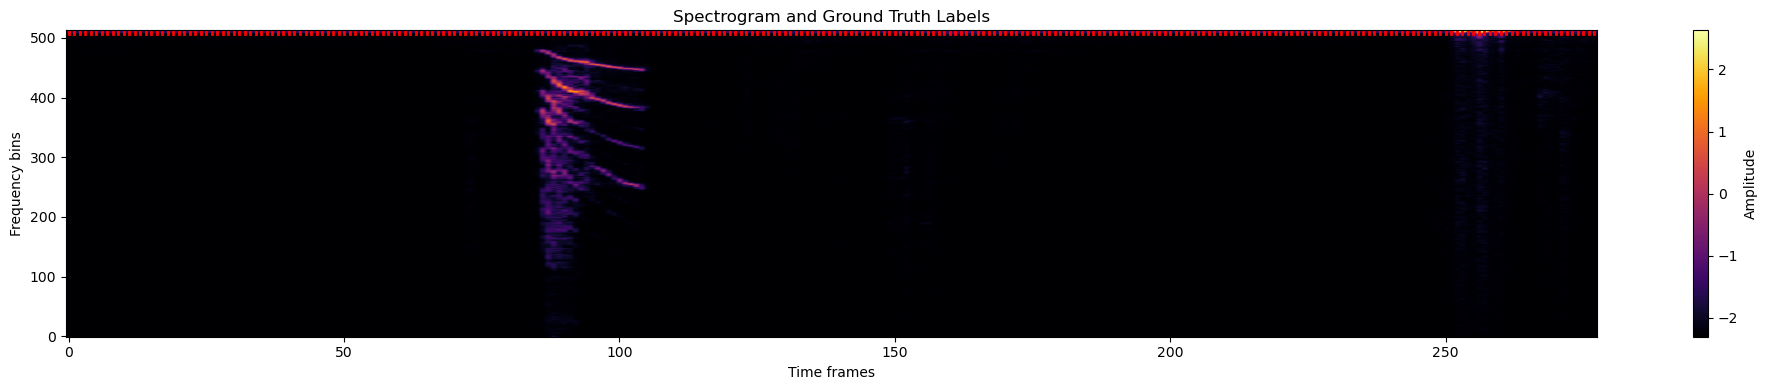

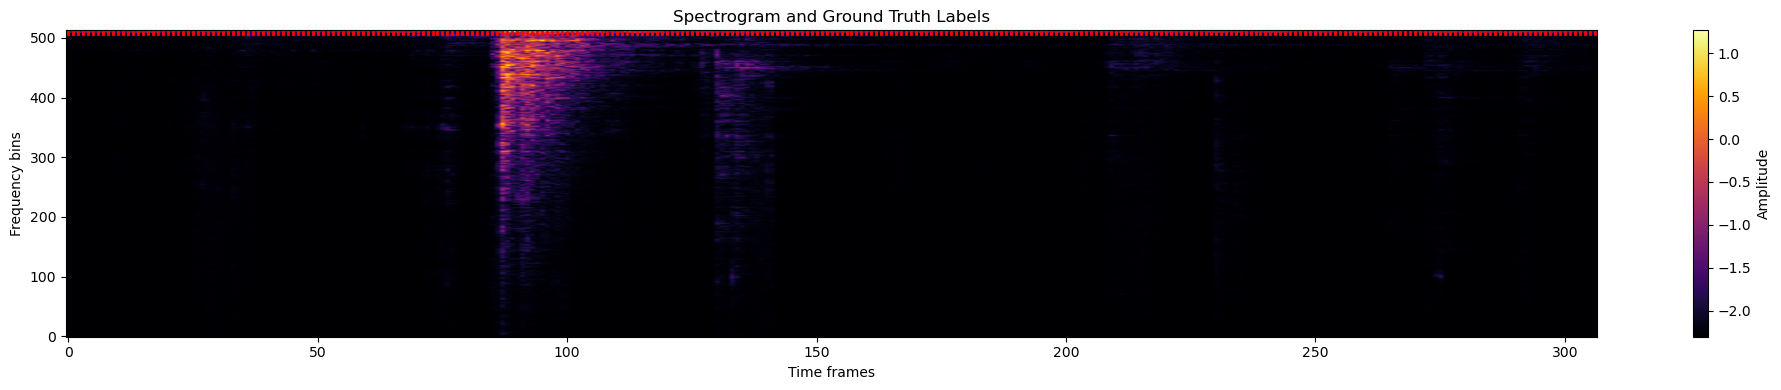

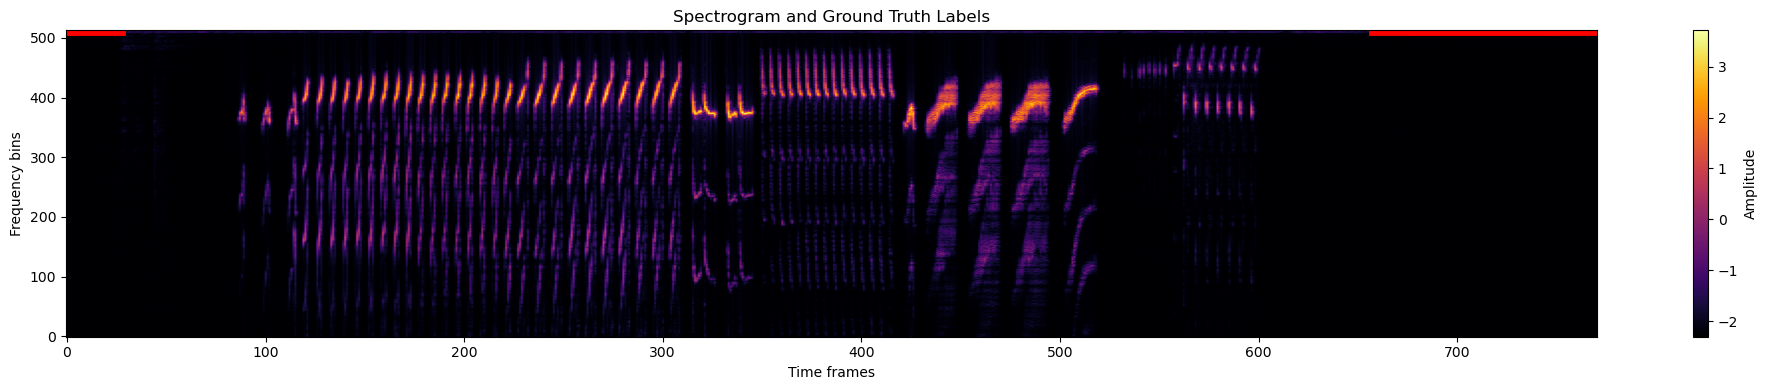

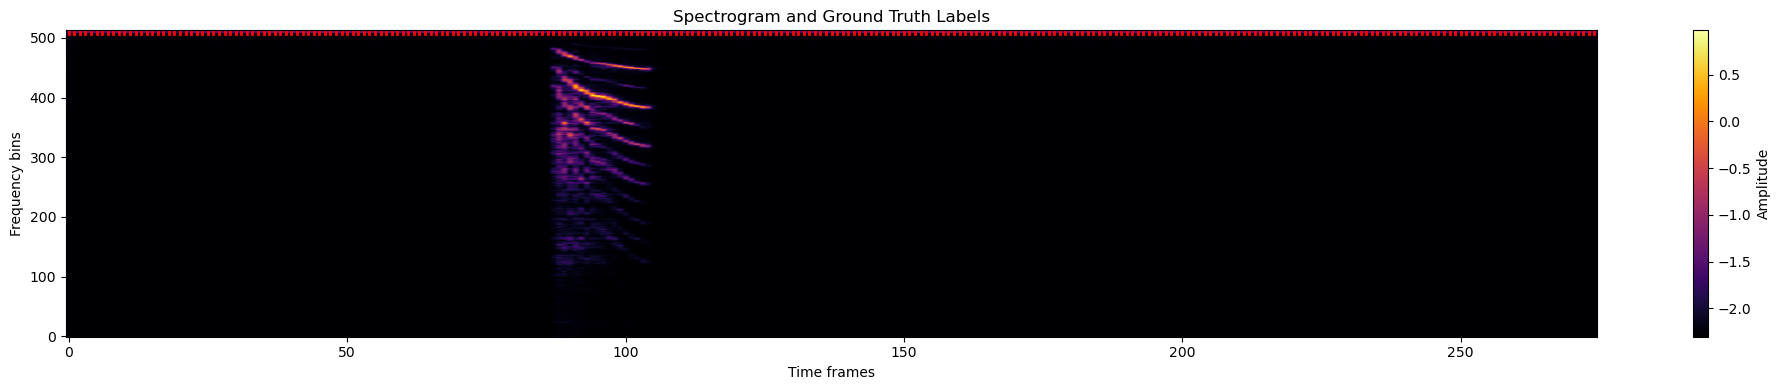

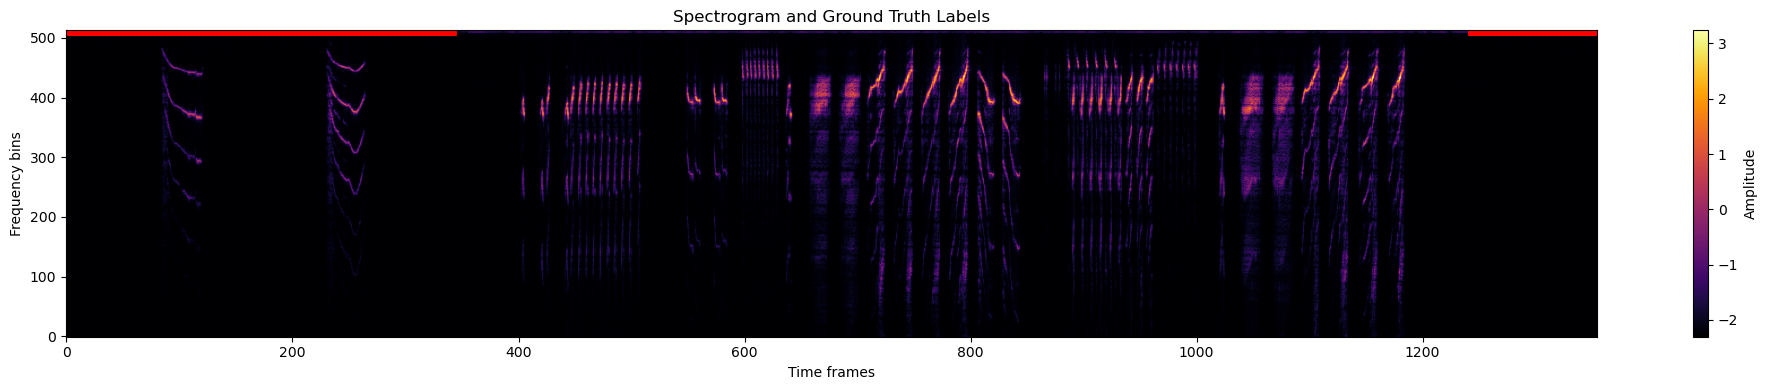

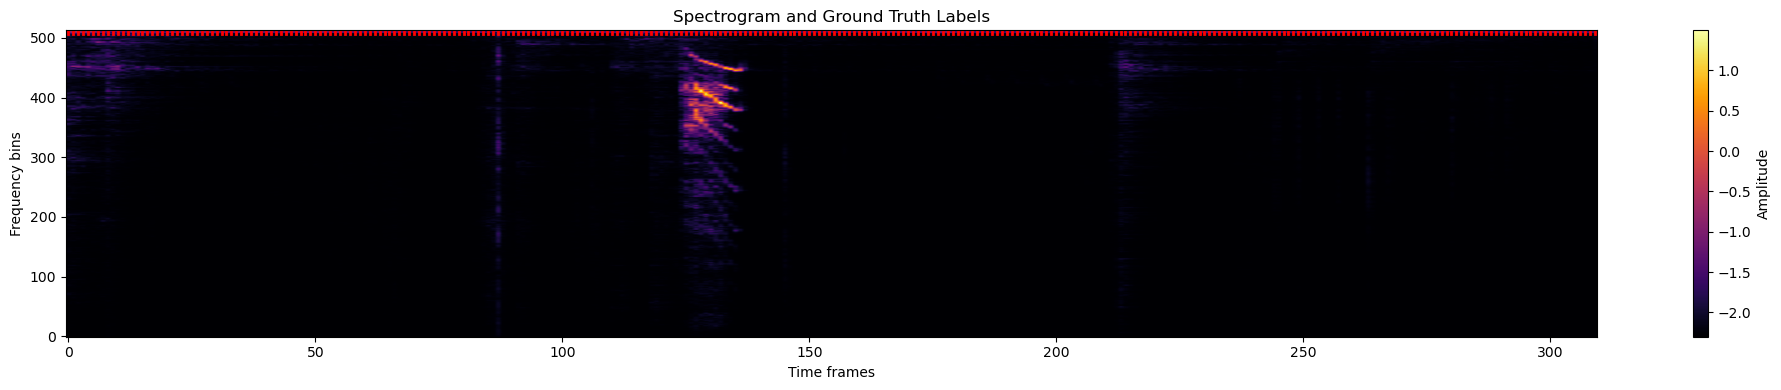

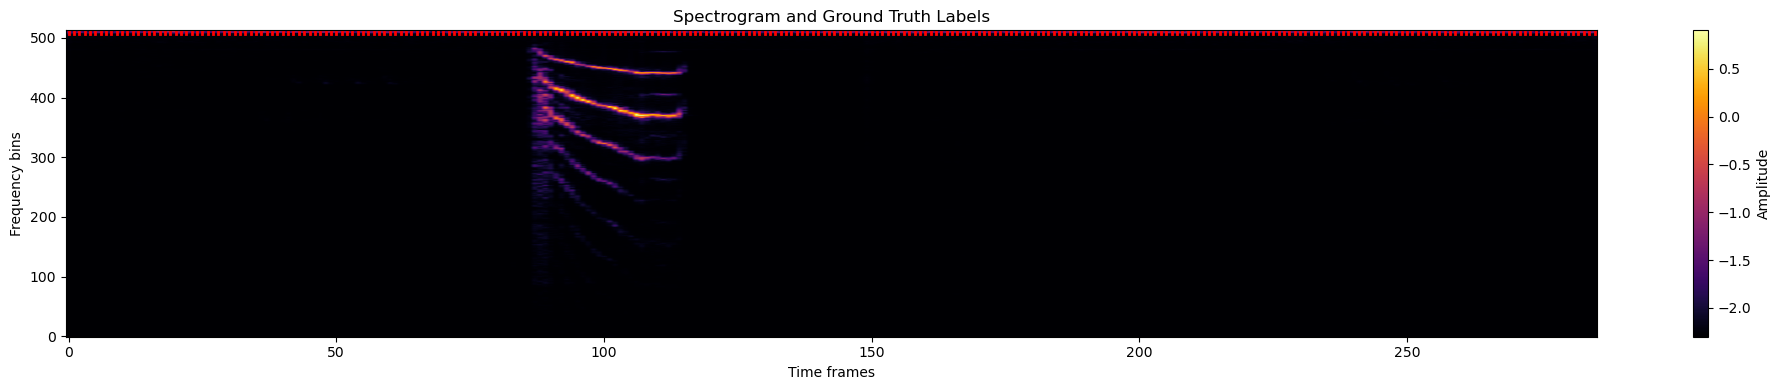

In [271]:
from inference_functions import replace_short_sequences, pad_and_relabel, plot_spectrogram_and_labels

#### 1 should always be non-song, and 0 should always be song #### Thats why I will generate an empty spectogram and see the labels and invert them if they are wrong
test = np.zeros((1, 492, 286))
test = torch.Tensor(test)
output_test, _ = model.inference_forward(test.unsqueeze(0).to(device))
labels_test = kmeans.predict(output_test[0].detach().cpu().numpy())

if labels_test.all() == 1:
    invert_labels = False 
else:
    invert_labels = True 


for i, file in enumerate(os.listdir("/home/george-vengrovski/Documents/canary_song_detector/data/")):
    f = np.load(os.path.join(data_root, file))
    spectogram = f['s']
    spectogram = spectogram[8:500,:]
    # Normalize (Z-score normalization)
    mean = spectogram.mean()
    std = spectogram.std()
    spectogram = (spectogram - mean) / (std + 1e-7)  # Adding a small constant to prevent division by zero

    # Replace NaN values with zeros
    spectogram[np.isnan(spectogram)] = 0
    spectogram = torch.from_numpy(spectogram).float().unsqueeze(0)
    output, _ = model.inference_forward(spectogram.unsqueeze(0).to(device))

    labels = kmeans.predict(output[0].detach().cpu().numpy())
    
    if invert_labels:
        # invert labels 
        labels = (1-labels)

    # the order of below functions is important, 1 is NOT SONG 
    labels = replace_short_sequences(labels, target_label=1, min_length=50)
    labels = replace_short_sequences(labels, target_label=0, min_length=200)

    # pad song
    labels = pad_and_relabel(labels, target_label=0, n=50)

    
    plot_spectrogram_and_labels(f['s'], labels)

    if i > 5:
        break